<a href="https://colab.research.google.com/github/npavani10/Stock-Analysis/blob/main/CombinedCode_OLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


# Fetch data
symbols = ['PLTR', 'TSLA', 'UBER', 'META', 'OXY', '^GSPC', '^IRX']
start_date = '2019-01-01'
end_date = '2023-12-31'
data = yf.download(symbols, start=start_date, end=end_date, interval='1mo')['Adj Close'].dropna()


# Calculate returns
returns = data.pct_change()

[*********************100%%**********************]  7 of 7 completed


In [ ]:
print(data.describe())
print(data.info())
print(data.head())
print(data.tail())


Ticker        META        OXY       PLTR        TSLA       UBER        ^GSPC  \
count    39.000000  39.000000  39.000000   39.000000  39.000000    39.000000   
mean    256.163080  46.150212  16.240769  245.372990  39.832820  4174.268442   
std      78.214203  18.983555   7.371492   58.333289  10.668978   346.456139   
min      93.061264   8.898301   6.420000  123.180000  20.459999  3269.959961   
25%     196.846146  27.128824   8.930000  207.933334  31.264999  3962.574951   
50%     272.870483  56.940823  14.980000  240.080002  39.139999  4179.830078   
75%     323.671570  61.685202  22.995001  266.339996  49.559999  4479.020020   
max     378.977905  71.340965  35.180000  381.586670  61.570000  4769.830078   

Ticker       ^IRX  
count   39.000000  
mean     2.220462  
std      2.275018  
min      0.003000  
25%      0.048000  
50%      1.030000  
75%      4.647500  
max      5.320000  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2020-10-01 to 2023-12-01
Freq: MS


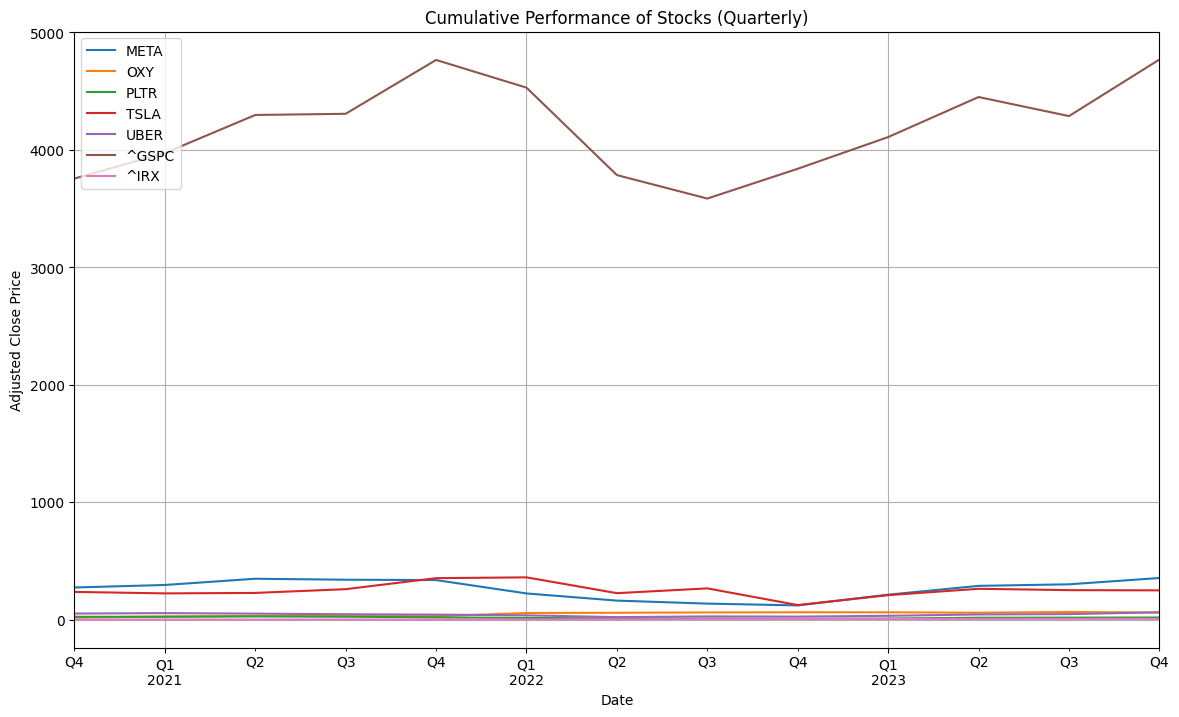

In [ ]:
# Resample data by quarter
data_quarterly = data.resample('Q').last()


# Compare cumulative performance by quarter
data_quarterly.plot(figsize=(14, 8))
plt.title('Cumulative Performance of Stocks (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


In [ ]:
import statsmodels.api as sm


# Function to calculate alpha and beta
def calculate_alpha_beta(symbol, returns):
    X = sm.add_constant(returns['^GSPC'])
    y = returns[symbol]
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    alpha = results.params[0]
    beta = results.params[1]
    return alpha, beta


# Calculate alpha and beta for each stock and portfolio
alphas = {}
betas = {}
for symbol in symbols:
    alpha, beta = calculate_alpha_beta(symbol, returns)
    alphas[symbol] = alpha
    betas[symbol] = beta


# Print alphas and betas
print("Alphas:")
for symbol, alpha in alphas.items():
    print(f"{symbol}: {alpha}")
print("\nBetas:")
for symbol, beta in betas.items():
    print(f"{symbol}: {beta}")


Alphas:
PLTR: 0.02424872773060225
TSLA: 0.01043687318456226
UBER: 0.009019229308818745
META: 0.005210310090368661
OXY: 0.05018602010286847
^GSPC: 0.0
^IRX: 0.3558834272969507

Betas:
PLTR: 2.707301748147161
TSLA: 2.1338523162241847
UBER: 1.4810670123512755
META: 0.9794495168707418
OXY: 1.1057801399314378
^GSPC: 0.9999999999999996
^IRX: -3.5179153113397343


PAVANI

In [ ]:
# Function to perform regression and test alphas
def test_alphas(returns, symbols):
    results = {}
    for symbol in symbols:
        if symbol == '^GSPC':  # Exclude market index itself
            continue
        X = sm.add_constant(returns['^GSPC'])  # Market returns as the independent variable
        y = returns[symbol]  # Stock returns as the dependent variable
        model = sm.OLS(y, X, missing='drop')
        fit = model.fit()
        alpha = fit.params['const']
        p_value = fit.pvalues['const']
        significant = p_value < 0.05  # Test at 5% significance level
        results[symbol] = (alpha, p_value, significant)
    return results

# Execute the function
alpha_results = test_alphas(returns, symbols)

# Print the results
for symbol, (alpha, p_value, significant) in alpha_results.items():
    significance_str = "significant" if significant else "not significant"
    print(f"{symbol}: Alpha = {alpha:.4f}, P-value = {p_value:.4f} ({significance_str})")

PLTR: Alpha = 0.0242, P-value = 0.6638 (not significant)
TSLA: Alpha = 0.0104, P-value = 0.6986 (not significant)
UBER: Alpha = 0.0090, P-value = 0.6678 (not significant)
META: Alpha = 0.0052, P-value = 0.7926 (not significant)
OXY: Alpha = 0.0502, P-value = 0.0685 (not significant)
^IRX: Alpha = 0.3559, P-value = 0.0382 (significant)


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

def rolling_alpha_analysis(data, symbol, window=3):

    results = pd.DataFrame(index=data.index, columns=['alpha', 'p_value'])

    # Clean data to remove or fill NaNs and infs
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    for end in range(window, len(data)):
        start = end - window
        y = data[symbol][start:end]
        X = sm.add_constant(data['^GSPC'][start:end])

        try:
            model = sm.OLS(y, X).fit()
            results.loc[data.index[end], 'alpha'] = model.params['const']

            # Calculate p-value from t-test statistic
            t_test_stat = model.tvalues['const']
            df = model.df_resid
            p_value = 2 * (1 - stats.t.cdf(np.abs(t_test_stat), df))
            results.loc[data.index[end], 'p_value'] = p_value
        except Exception as e:
            print(f"Error occurred at index {data.index[end]}: {e}")
            results.loc[data.index[end], 'alpha'] = np.nan
            results.loc[data.index[end], 'p_value'] = np.nan

    return results

# Assuming 'returns_data' contains your stock and market index returns
returns_data = returns.dropna()
rolling_results = rolling_alpha_analysis(returns_data, 'TSLA', window=3)
print(rolling_results)


               alpha   p_value
Date                          
2020-11-01       NaN       NaN
2020-12-01       NaN       NaN
2021-01-01       NaN       NaN
2021-02-01  0.149116  0.050794
2021-03-01  0.073541  0.789658
2021-04-01   0.05245  0.712617
2021-05-01 -0.357081  0.021195
2021-06-01 -0.142903  0.132574
2021-07-01 -0.077725  0.613246
2021-08-01 -0.170989   0.26996
2021-09-01 -0.007181  0.982151
2021-10-01  0.045405   0.31752
2021-11-01  0.138639  0.441159
2021-12-01  0.157028  0.274015
2022-01-01 -0.017393  0.957104
2022-02-01 -0.052477  0.538104
2022-03-01 -0.083578  0.123266
2022-04-01  0.084181  0.151573
2022-05-01  0.089497  0.270984
2022-06-01  0.023594  0.873715
2022-07-01 -0.127362  0.262644
2022-08-01  0.021461  0.873659
2022-09-01  0.077078   0.23018
2022-10-01  0.103467  0.346356
2022-11-01 -0.095228  0.013112
2022-12-01  -0.09938  0.050843
2023-01-01 -0.260948  0.046962
2023-02-01  -0.11986  0.685327
2023-03-01   0.11902  0.590548
2023-04-01  0.164223  0.530717
2023-05-

PRANAY

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
# Define the stock symbols
stocks = ['PLTR', 'TSLA', 'UBER', 'META', 'OXY']
# Set the time period
start_date = '2019-01-01'
end_date = '2023-12-31'
# Download historical stock data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']


# Calculate daily returns
daily_returns = data.pct_change()
# Assume a constant risk-free rate over the period
# Note: You might want to use a dynamic risk-free rate fetched from an external source for more accuracy
risk_free_rate = 0.0466
daily_risk_free_return = risk_free_rate / 252  # Convert annual rate to daily
# Calculate excess returns by subtracting the daily risk-free return
excess_returns = daily_returns - daily_risk_free_return
# Calculate the average annualized Sharpe ratio
annual_sharpe_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252))
# Print the Sharpe Ratios
print("Annualized Sharpe Ratios:")
print(annual_sharpe_ratio)


[*********************100%%**********************]  5 of 5 completed


Annualized Sharpe Ratios:
Ticker
META    0.555763
OXY     0.287295
PLTR    0.544584
TSLA    1.022457
UBER    0.342680
dtype: float64


[*********************100%%**********************]  5 of 5 completed


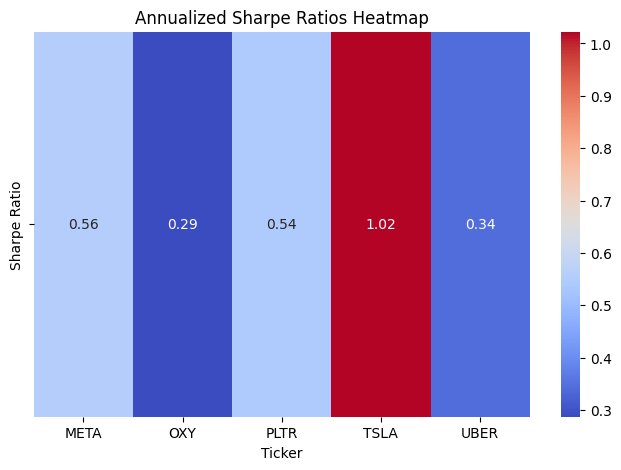

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
# Define the stock symbols
stocks = ['PLTR', 'TSLA', 'UBER', 'META', 'OXY']
# Set the time period
start_date = '2019-01-01'
end_date = '2023-12-31'
# Download historical stock data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
# Calculate daily returns
daily_returns = data.pct_change()


# Assume a constant risk-free rate over the period
risk_free_rate = 0.0466
daily_risk_free_return = risk_free_rate / 252  # Convert annual rate to daily
# Calculate excess returns by subtracting the daily risk-free return
excess_returns = daily_returns - daily_risk_free_return
# Calculate the average annualized Sharpe ratio
annual_sharpe_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252))
# Convert the Sharpe Ratio Series to a DataFrame
sharpe_ratio_df = pd.DataFrame(annual_sharpe_ratio, columns=['Sharpe Ratio'])
# Plotting the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(sharpe_ratio_df.T, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Annualized Sharpe Ratios Heatmap')
plt.show()


[*********************100%%**********************]  6 of 6 completed


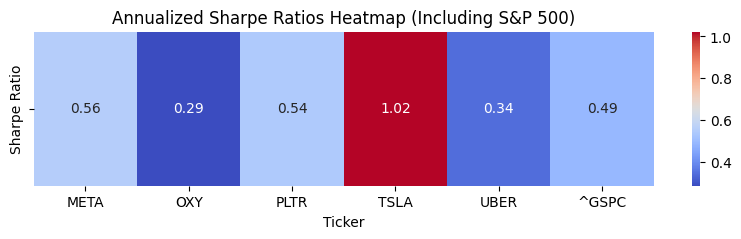

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
# Define the stock symbols and include the S&P 500
stocks = ['PLTR', 'TSLA', 'UBER', 'META', 'OXY']
index_symbol = '^GSPC'  # S&P 500 symbol
# Set the time period
start_date = '2019-01-01'
end_date = '2023-12-31'


# Download historical stock data and S&P 500 data
stock_data = yf.download(stocks + [index_symbol], start=start_date, end=end_date)['Adj Close']
# Calculate daily returns for stocks and S&P 500
daily_returns = stock_data.pct_change()
# Assume a constant risk-free rate over the period (you can replace this with actual T-bill rates if available)
risk_free_rate = 0.0466
daily_risk_free_return = risk_free_rate / 252  # Convert annual rate to daily
# Calculate excess returns by subtracting the daily risk-free return
excess_returns = daily_returns - daily_risk_free_return
# Calculate the average annualized Sharpe ratio for stocks and S&P 500
annual_sharpe_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252))
# Create a DataFrame for the heatmap (including the S&P 500)
sharpe_ratio_df = pd.DataFrame(annual_sharpe_ratio, columns=['Sharpe Ratio'])
# Plot the heatmap including the S&P 500
plt.figure(figsize=(10, 2))  # Adjust the figure size as needed
sns.heatmap(sharpe_ratio_df.T, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Annualized Sharpe Ratios Heatmap (Including S&P 500)')
plt.show()


[*********************100%%**********************]  6 of 6 completed


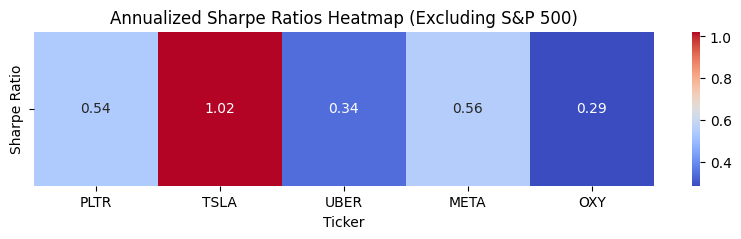

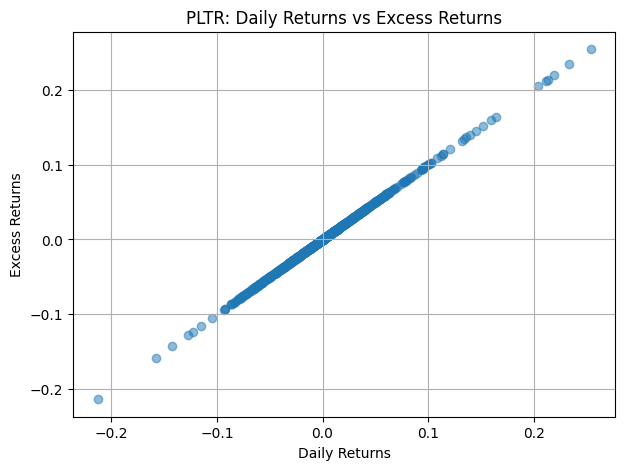

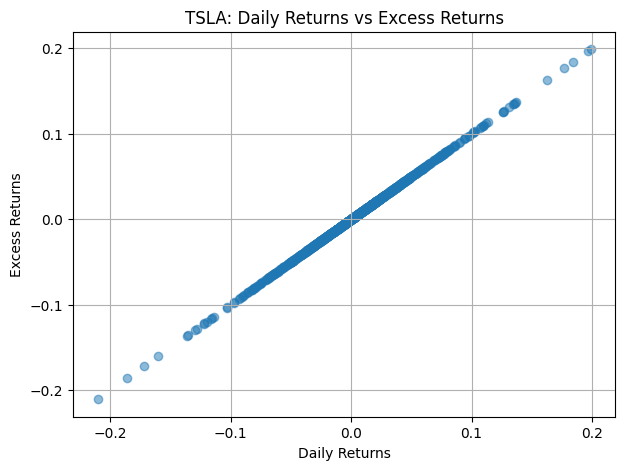

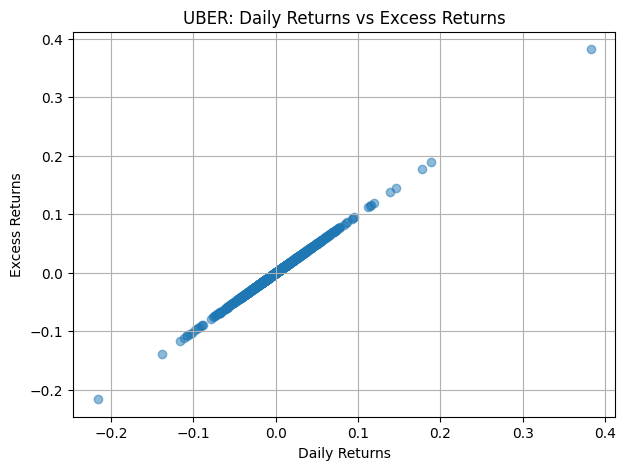

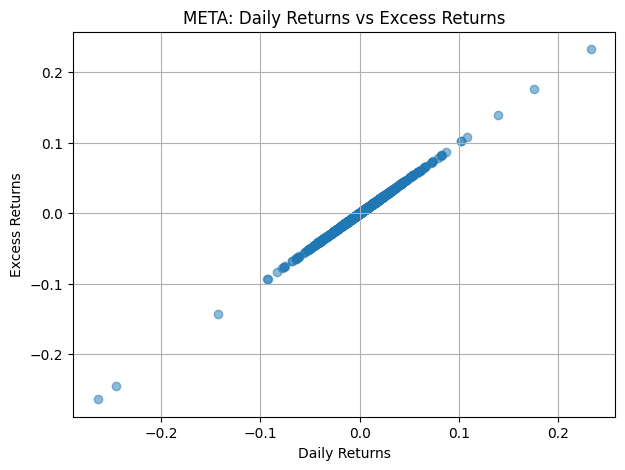

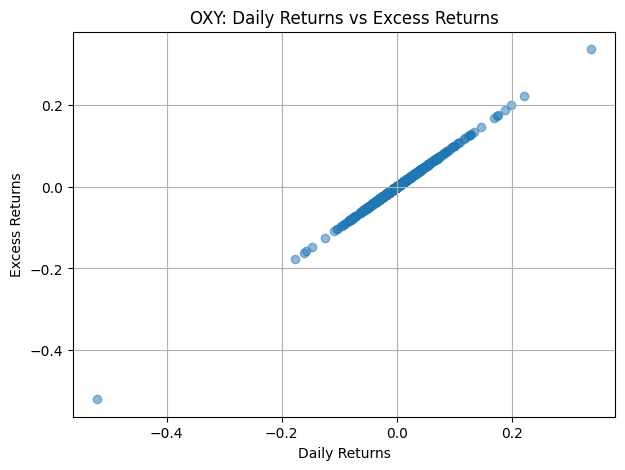

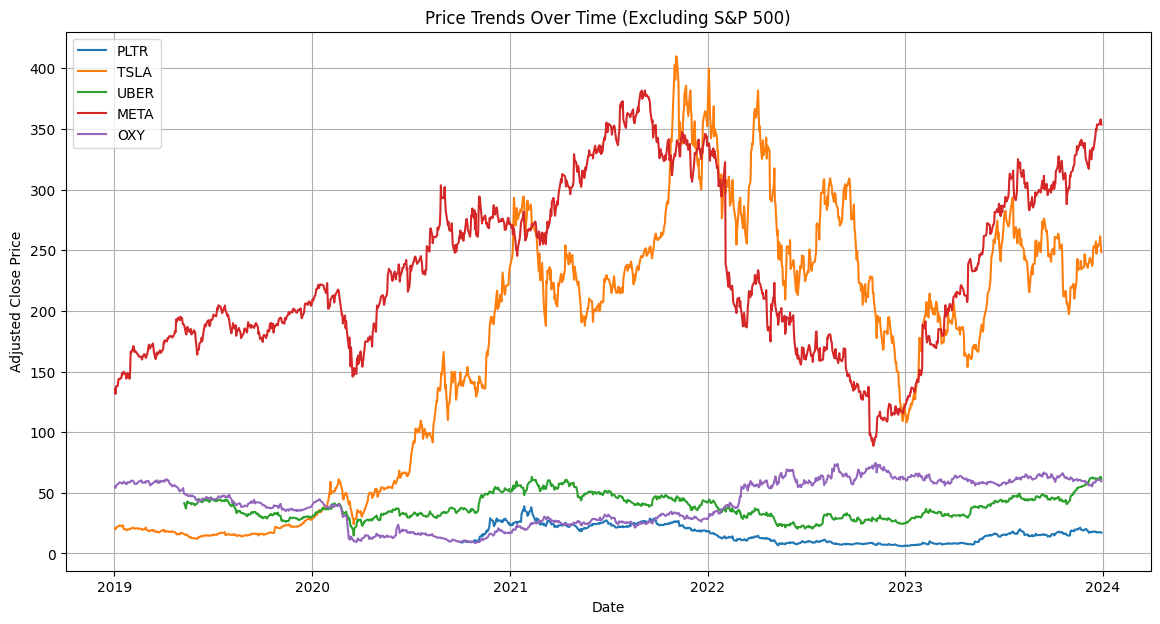

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
# Define the stock symbols and include the S&P 500 for data fetching
stocks = ['PLTR', 'TSLA', 'UBER', 'META', 'OXY']
index_symbol = '^GSPC'  # S&P 500 symbol
# Set the time period
start_date = '2019-01-01'
end_date = '2023-12-31'
# Download historical stock data including the S&P 500
stock_data = yf.download(stocks + [index_symbol], start=start_date, end=end_date)['Adj Close']
# Calculate daily returns for stocks and S&P 500
daily_returns = stock_data.pct_change()
# Assume a constant risk-free rate over the period
risk_free_rate = 0.0466
daily_risk_free_return = risk_free_rate / 252  # Convert annual rate to daily
# Calculate excess returns by subtracting the daily risk-free return
excess_returns = daily_returns - daily_risk_free_return
# Calculate the average annualized Sharpe ratio for stocks
annual_sharpe_ratio = (excess_returns[stocks].mean() * 252) / (excess_returns[stocks].std() * np.sqrt(252))
# Create a DataFrame for the heatmap (excluding the S&P 500)
sharpe_ratio_df = pd.DataFrame(annual_sharpe_ratio, columns=['Sharpe Ratio'])
# Plotting the heatmap excluding the S&P 500
plt.figure(figsize=(10, 2))
sns.heatmap(sharpe_ratio_df.T, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Annualized Sharpe Ratios Heatmap (Excluding S&P 500)')
plt.show()
# Plotting scatter plots for each stock excluding the S&P 500
for stock in stocks:
    plt.figure(figsize=(7, 5))
    plt.scatter(daily_returns[stock], excess_returns[stock], alpha=0.5)
    plt.title(f'{stock}: Daily Returns vs Excess Returns')
    plt.xlabel('Daily Returns')
    plt.ylabel('Excess Returns')
    plt.grid(True)
    plt.show()


# Line Charts for Stock Prices excluding S&P 500
plt.figure(figsize=(14, 7))
for stock in stocks:
    plt.plot(stock_data[stock], label=stock)
plt.title('Price Trends Over Time (Excluding S&P 500)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()
